# Project Description

#### We are using a CNN, max pooling, and n-grams (a sequence of n words in a sentence) to construct this project

## Imporant Documentation

### PyTorch Resources:
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
#####    - https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058#:~:text=An%20N%2Dgram%20means%20a,3%2Dgram%20(trigram).

### Step 0: Import Libraries

In [1]:
import re
import nltk
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sn
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# IMPORTANT: Use this variable to activate training.
# Set to false when you want to run-all to load an existing model and test on custom phrases.
TRAINING_MODE = True

### Step 1: Tokenize data and build vocab

In [2]:
class Preprocessed_Dataset:
    FILE_NAME = 'clickbait_data.csv'
    
    def __init__(self, vocab_size, sequence_length):
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.vocab = None
        self.x_tokenized = None
        self.x_padded = None
        self.x = None
        self.y = None

        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def load_dataset(self):
        # Load dataset from local directory 
        data_frame = pd.read_csv(self.FILE_NAME)
        
        data_frame = shuffle(data_frame, random_state=64209)
        self.x = data_frame['headline'].to_numpy()
        self.y = data_frame['clickbait'].to_numpy()

    def clean_data(self):
        # Clean data by removing all special characters. Convert words to lowercase
        self.x = [re.sub(r'\'','', headline).lower() for headline in self.x]
        self.x = [re.sub(r'[^A-Za-z0-9]+',' ', headline).lower() for headline in self.x]

    def tokenization(self):
        # Tokenize all headlines
        self.x = [nltk.tokenize.wordpunct_tokenize(headline) for headline in self.x]

    def build_vocab(self):
        # Build vocab and return 'vocab_size' most common words
        self.vocab = dict()

        frequiencies = nltk.FreqDist()
        for headline in self.x:
            for word in headline:
                frequiencies[word] += 1
        
        common_words = frequiencies.most_common(self.vocab_size)

        for count, word in enumerate(common_words):
            self.vocab[word[0]] = count+1
    
    def word_to_idx(self):	
        # Convert each token into index based representation 
        self.x_tokenized = list()
        
        for sentence in self.x:
            temp = list()
            for word in sentence:
                if word in self.vocab.keys():
                    temp.append(self.vocab[word])
            self.x_tokenized.append(temp)
    
    def padding_sentences(self):
        # Make all sentences equal length. 
        # If sentence is smaller than minimum length, pad it 
        zero_pad = 0
        self.x_padded = list()

        for sentence in self.x_tokenized:
            while len(sentence) < self.sequence_length:
                sentence.insert(len(sentence), zero_pad)
            while len(sentence) > self.sequence_length: #Truncation in case the sequence length is too short
                print("Sentence is long, consider increasing the sequence length to prevent vocab dropping.")
                sentence.pop()
            self.x_padded.append(sentence)
            
        self.x_padded = np.array(self.x_padded)

    def split_data(self):
        # Split data into training and testing sets
        train_size = int(len(self.x_padded) * .8)
        self.x_train = self.x_padded[:train_size]
        self.y_train = self.y[:train_size]
        self.x_test = self.x_padded[train_size:]
        self.y_test = self.y[train_size:]
    
    def get_tokenized_string(self, sentence) -> list:
        # Use local dataset to tokenize a single string for user testing
        string = sentence
        string = re.sub(r'\'','', string).lower()
        string = re.sub(r'[^A-Za-z0-9]+',' ', string).lower()
        string = nltk.tokenize.wordpunct_tokenize(string)
        x_tokenized = list()
        zero_pad = 0
        for word in string:
            if word in self.vocab.keys():
                x_tokenized.append(self.vocab[word])
        while len(x_tokenized) < self.sequence_length:
            x_tokenized.insert(len(string), zero_pad)
        while len(x_tokenized) > self.sequence_length:
            print("Sentence is long, consider increasing the sequence length to prevent vocab dropping.")
            x_tokenized.pop()
        x_padded = x_tokenized
        return np.array([x_padded])


### Step 2: Build the Model

In [3]:
class HeadlineClassifier(torch.nn.ModuleList):
    def __init__(self, sequence_length, num_words, embedding_size, dropout, out_size, stride, filters, device):
        super(HeadlineClassifier, self).__init__()

        self.to(device) #Move to CPU or GPU
        self.device = device

        self.sequence_length = sequence_length
        self.num_words = num_words
        self.embedding_size = embedding_size

        # Dropout (used to reduce chance of overfitting by "dropping" units in neural net). Probability (p) set to 0.25
        self.dropout = torch.nn.Dropout(dropout)

        # Kernel sizes for the CNN
        self.filters = filters

        # Output size for convolutions
        self.out_size = out_size
        # Number of strides for convolutions
        self.stride = stride

        # Embedding layer (lookup table that stores embeddings of a fixed dictionary and size)
        self.embedding = torch.nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0).to(self.device)

        # Convolution layers (each is a 1D convolution over an input)
        self.convolution_layers = [torch.nn.Conv1d(self.sequence_length, self.out_size, fltr, self.stride) for fltr in self.filters]
        for layer in self.convolution_layers:
            layer = layer.to(self.device) #Used to transer model data to GPU when training on CUDA
        
            
        # Max pooling layers (each applies 1D max pooling to input) 
        self.pool_layers = [torch.nn.MaxPool1d(fltr, self.stride) for fltr in self.filters]
        for layer in self.pool_layers:
            layer = layer.to(self.device) #Used to transer model data to GPU when training on CUDA

        # Fully connected layer (applies linear transformation to data)
        self.fully_connected_layer = torch.nn.Linear(self.size_of_input(), 1).to(self.device)

        # Evaluation metrics
        self.train_eval_info = {
            "accuracy": 0,
            "precision": 0,
            "recall": 0,
            "tpr": 0,
            "fpr": 0,
            "tp": 0,
            "fp": 0,
            "tn": 0,
            "fn": 0
        }

        self.test_eval_info = {
            "accuracy": 0,
            "precision": 0,
            "recall": 0,
            "tpr": 0,
            "fpr": 0,
            "tp": 0,
            "fp": 0,
            "tn": 0,
            "fn": 0
        }

    
    def size_of_input(self):
        # Calculate input size for linear layer 
        pout = 0
        for filter in self.filters:
            cout = math.floor(((self.embedding_size - (filter - 1) - 1)/self.stride) + 1)
            pout += math.floor(((cout - (filter - 1) - 1) / self.stride) + 1)
        
        return pout * self.out_size

    '''
    Create forward pass of neural network. Consists of mainly ordering the different types of layers
        Steps:
            1. Pass tokenized words through embedding layer
            2. Pass each embedded sentence through each convolution and max pooling layer
            3. Reduce vector to linear layer
    '''
    def forward(self, input_X):
        x = self.embedding(input_X)

        layer_passes = list()
        for i in range(len(self.filters)):
            temp = self.convolution_layers[i](x)
            temp = torch.relu(temp).to(self.device)
            temp = self.pool_layers[i](temp)
            layer_passes.append(temp)

        merged_layers = torch.cat(layer_passes, 2)
        merged_layers = merged_layers.reshape(merged_layers.size(0), -1)
        output = torch.sigmoid(self.dropout(self.fully_connected_layer(merged_layers))).squeeze()
        return output


### Step 3: Train Model

In [4]:
# Train model
# Returns: Training Loss, Testing Loss, Training Accuracy, Testing Accuracy, Evaluated Training List, Evaluated Testing List
def train(model, dataset, learning_rate, batch_size, train_data, test_data, num_of_iterations, device):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size)

    opt = torch.optim.SGD(model.parameters(), lr = learning_rate)

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for iter in range(num_of_iterations):
        model.train()
        train_predictions = []

        for x,y in train_loader:
            if device == 'cuda':
                y = y.type(torch.cuda.FloatTensor)
            else:
                y = y.type(torch.FloatTensor)
            pred = model(x) # Forward pass on input data
            loss = torch.nn.functional.mse_loss(pred, y).to(device) # Measure the MSE between the target and input

            opt.zero_grad() # Set gradients to zero 

            loss.backward()

            opt.step()

            train_predictions += list(pred.cpu().detach().numpy()) # Append training predictions 

        # Evaluate model
        model.eval() # Put model in evaluation mode
        test_predictions = []
        with torch.no_grad(): # Disable gradient calculation for speed purposes
            for x, y in test_loader:
                pred = model(x)
                test_predictions += list(pred.cpu().detach().numpy()) # Append test predictions

        # Get model accuracy 
        # train_eval = [accuracy, precision, recall, true-positive-rate, false-positive-rate, true_pos, false_pos, true_neg, false_neg]
        train_eval = evaluate(dataset.y_train, train_predictions)
        test_eval = evaluate(dataset.y_test, test_predictions)
        train_loss = loss.item()
        test_loss = loss.item()
        
        # Gather training and testing loss & accuracy
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_eval[0])
        test_accuracies.append(test_eval[0])
        
        # Print training and testing accuracy for each iteration
        print("Training -- Iteration: %d, Loss: %.5f, Accuracy: %.5f, Precision: %.5f, Recall: %.5f, TPR: %.5f, FPR: %.5f" % (iter+1, train_loss, train_eval[0], train_eval[1], train_eval[2], train_eval[3], train_eval[4]))
        print("Testing -- Iteration: %d, Loss: %.5f, Accuracy: %.5f, Precision: %.5f, Recall: %.5f, TPR: %.5f, FPR: %.5f" % (iter+1, test_loss, test_eval[0], test_eval[1], test_eval[2], test_eval[3], test_eval[4]))

    # Update model's evaluation metrics
    model.train_eval_info['accuracy'] = train_accuracies
    model.train_eval_info['precision'] = train_eval[1]
    model.train_eval_info['recall'] = train_eval[2]
    model.train_eval_info['tpr'] = train_eval[3]
    model.train_eval_info['fpr'] = train_eval[4]
    model.train_eval_info['tp'] = train_eval[5]
    model.train_eval_info['fp'] = train_eval[6]
    model.train_eval_info['tn'] = train_eval[7]
    model.train_eval_info['fn'] = train_eval[8]

    model.test_eval_info['accuracy'] = test_accuracies
    model.test_eval_info['precision'] = test_eval[1]
    model.test_eval_info['recall'] = test_eval[2]
    model.test_eval_info['tpr'] = test_eval[3]
    model.test_eval_info['fpr'] = test_eval[4]
    model.test_eval_info['tp'] = test_eval[5]
    model.test_eval_info['fp'] = test_eval[6]
    model.test_eval_info['tn'] = test_eval[7]
    model.test_eval_info['fn'] = test_eval[8]

    return (train_losses, test_losses)
        

### Step 4: Build Supporting Classes and Functions

In [5]:
class DataClass(torch.utils.data.TensorDataset):
   def __init__(self, x, y):
      self.x = x
      self.y = y
      
   def __len__(self):
      return len(self.x)
      
   def __getitem__(self, idx):
      return self.x[idx], self.y[idx]

In [6]:
# Get accuracy of model 
# Returns Accuracy, Precision, Recall, True-Positive-Rate, False-Positive-Rate
def evaluate(actual, predictions):
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0

    for true, pred in zip(actual, predictions):
        if (pred >= 0.5) and (true == 1): # True positive (prediction is 'clickbait' and actual is 'clickbait')
            true_pos += 1
        elif (pred >= 0.5) and (true == 0): # False positive (prediction is 'clickbait' and actual is 'not clickbait')
            false_pos += 1
        elif (pred < 0.5) and (true == 0): # True negative (prediction is 'not clickbait' and actual is 'not clickbait')
            true_neg += 1
        elif (pred < 0.5) and (true == 1): # False negative (prediction is 'not clickbait' and actual is 'clickbait')
            false_neg += 1
    

    # Return accuracy of model
    accuracy = (true_pos + true_neg) / len(actual)
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) != 0 else 0 #Prevent divide by 0 if we had no clickbait predictions
    recall = true_pos / (true_pos + false_neg)
    true_pos_rate = true_pos / (true_pos + false_neg)
    false_pos_rate = false_pos / (false_pos + true_neg)

    return [accuracy, precision, recall, true_pos_rate, false_pos_rate, true_pos, false_pos, true_neg, false_neg]


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("--------------Found CUDA device. Training on GPU.--------------")
else:
    print("--------------Training on CPU--------------")
    
# Initialization variables
sequence_length = 30

# Initialize instance of Preprocessed_Dataset class
dataset = Preprocessed_Dataset(100_000, sequence_length)

# Load dataset
dataset.load_dataset()

# Clean and tokenize dataset
dataset.clean_data()
dataset.tokenization()

# Build vocab 
dataset.build_vocab()

# Index words and pad headline sentences
dataset.word_to_idx()
dataset.padding_sentences()

# Split data into training and testing sets
dataset.split_data()

# Print data specifics:
print("Dataset size: ", len(dataset.x))
print("Dataset training size: ", len(dataset.y_train))
print("Dataset testing size: ", len(dataset.x_test))

vocab_size = len(dataset.vocab)
embedding_size = 64
dropout = 0.25
out_size = 25
stride = 2
filters = [2,3,4,5]
model = HeadlineClassifier(sequence_length, vocab_size, embedding_size, dropout, out_size, stride, filters, device)

# Model save paths model
save_path = Path("model-save-data/model.pth")
dict_path = Path("model-save-data/dict.pth")
cpu_flag_path = Path("model-save-data/cpu")
gpu_flag_path = Path("model-save-data/gpu")

--------------Found CUDA device. Training on GPU.--------------
Dataset size:  32000
Dataset training size:  25600
Dataset testing size:  6400


In [8]:
def confusion_matrix(tp, fp, tn, fn):
       arr = [[tp, fn],
              [fp, tn]]
       df_cm = pd.DataFrame(arr, index = [i for i in ["Clickbait", "Not Clickbait"]],
              columns = [i for i in ["Clickbait", "Not Clickbait"]])
       plt.figure(figsize = (10,7))
       sn.set(font_scale=2)
       sn.heatmap(df_cm, annot=True, fmt="d")
       plt.xlabel("Predicted Class",fontsize="20")
       plt.ylabel("Actual Class",fontsize="20")
       sn.set(font_scale=1)

### Step 5: Run Model!

In [9]:
if TRAINING_MODE:
    model = model.to(device)

    # Creating testing and training datasets
    train_set = torch.utils.data.TensorDataset(torch.Tensor(dataset.x_train).long().to(device), torch.Tensor(dataset.y_train).long().to(device))
    test_set = torch.utils.data.TensorDataset(torch.Tensor(dataset.x_test).long().to(device), torch.Tensor(dataset.y_test).long().to(device))

    # Train model
    learning_rate = 0.05
    batch_size = 12
    num_of_iterations = 50
    train_losses, test_losses = train(model, dataset, learning_rate, batch_size, train_set, test_set, num_of_iterations, device)

    # Delete old save data
    if save_path.exists():
        save_path.unlink()
    if cpu_flag_path.exists():
        cpu_flag_path.unlink()
    if gpu_flag_path.exists():
        gpu_flag_path.unlink()
    if dict_path.exists():
        dict_path.unlink()

    # Write save and training device marker
    torch.save(model, save_path)
    torch.save(dataset, dict_path)
    if device == 'cuda':
        Path(gpu_flag_path).touch()
    else:
        Path(cpu_flag_path).touch()

Training -- Iteration: 1, Loss: 0.17546, Accuracy: 0.64109, Precision: 0.61265, Recall: 0.76335, TPR: 0.76335, FPR: 0.48066
Testing -- Iteration: 1, Loss: 0.17546, Accuracy: 0.76500, Precision: 0.78278, Recall: 0.73860, TPR: 0.73860, FPR: 0.20819
Training -- Iteration: 2, Loss: 0.14709, Accuracy: 0.69883, Precision: 0.66191, Recall: 0.81032, TPR: 0.81032, FPR: 0.41221
Testing -- Iteration: 2, Loss: 0.14709, Accuracy: 0.71281, Precision: 0.92730, Recall: 0.46667, TPR: 0.46667, FPR: 0.03717
Training -- Iteration: 3, Loss: 0.13090, Accuracy: 0.71430, Precision: 0.67590, Recall: 0.82120, TPR: 0.82120, FPR: 0.39217
Testing -- Iteration: 3, Loss: 0.13090, Accuracy: 0.75766, Precision: 0.90474, Recall: 0.58016, TPR: 0.58016, FPR: 0.06205
Training -- Iteration: 4, Loss: 0.10830, Accuracy: 0.72066, Precision: 0.67996, Recall: 0.83161, TPR: 0.83161, FPR: 0.38983
Testing -- Iteration: 4, Loss: 0.10830, Accuracy: 0.79000, Precision: 0.87786, Recall: 0.67752, TPR: 0.67752, FPR: 0.09575
Training -- 

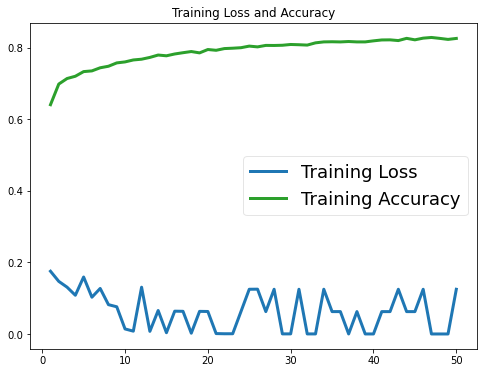

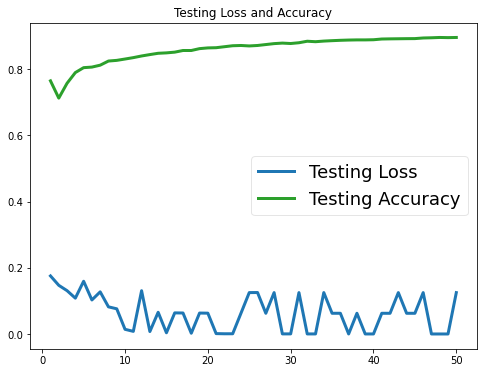

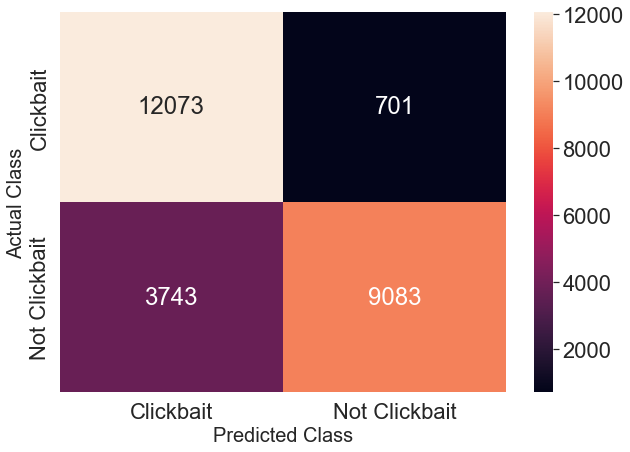

In [10]:
if TRAINING_MODE:
    #plot losses/accuracies
    x = list(range(1, num_of_iterations + 1))
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(x, train_losses, label='Training Loss', color='tab:blue', linewidth=3)
    plt.plot(x, model.train_eval_info['accuracy'], label='Training Accuracy', color='tab:green', linewidth=3)
    plt.title('Training Loss and Accuracy')
    plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
    plt.show()

    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(x, test_losses, label='Testing Loss', color='tab:blue', linewidth=3)
    plt.plot(x, model.test_eval_info['accuracy'], label='Testing Accuracy', color='tab:green', linewidth=3)
    plt.title('Testing Loss and Accuracy')
    plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
    plt.show()

    # Plot confusion matrix
    confusion_matrix(model.train_eval_info['tp'], model.train_eval_info['fp'], model.train_eval_info['tn'], model.train_eval_info['fn'])

In [11]:
save_device = 'cuda' if Path(gpu_flag_path).exists() else 'cpu'
my_device = 'cpu'
if save_device == 'cuda':
    model = torch.load(save_path, map_location=my_device)
else:
    model = torch.load(save_path)

model.device = 'cpu'
model = model.cpu()
model.eval()

dataset = torch.load(dict_path)

def predict(string) -> float:
    test_phrase = dataset.get_tokenized_string(string)
    pred = model(torch.tensor(test_phrase))
    return pred.detach().numpy()

def print_prediction(prediction):
    if prediction > 0.5:
        print("CLICKBAIT FOUND ( result =", prediction, ")")
    else:
        print("Not clickbait ( result =", prediction, ")")

set = pd.read_csv("generalization_set.csv")
correct = 0
for row in set.itertuples():
    if row[2] == 1 and predict(row[1]) > 0.5 or row[2] == 0.5 and predict(row[1]) < 0:
        correct += 1

def print_cnn(val):
    if val > 0:
        print("CLICKBAIT FOUND:", val)
    else:
        print("Not Clickbait", val)

print(str.format("Generalization Accuracy: {:.4f}", correct/set.shape[0]))

Generalization Accuracy: 0.3500


In [12]:
#Run a prediction test
print_prediction(predict("India plans to send a weather balloon in Venus atmosphere to study it"))

Not clickbait ( result = 0.12427208 )


# The LSTM Model
### Reference model: https://anujdutt9.github.io/text-sentiment-analysis-tensorflow

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

embedding_dim = 64
model_LSTM = tf.keras.Sequential([# Word Embeddings Layer, embeddings learnt as part of model training process
                           tf.keras.layers.Embedding(vocab_size, embedding_dim),
                           # Bi-directional LSTM
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units= 64)),
                           # Dense Layer
                           tf.keras.layers.Dense(units= 64, activation='relu'),
                           # Output Layer: Binary Output
                           tf.keras.layers.Dense(units= 1)
])


model_LSTM.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics= ['accuracy'])

Epochs = 10


# Validation StepsLeo
Valid_Steps = 10
# Train the Model
hist = model_LSTM.fit(x = dataset.x_train,
                 y = dataset.y_train,
                 epochs= Epochs,
                 validation_data= (dataset.x_test, dataset.y_test),
                 validation_steps= Valid_Steps,
                 workers=4)

Epoch 1/10
800/800 [==============================] - 5s 5ms/step - loss: 0.1083 - accuracy: 0.8801 - val_loss: 0.0354 - val_accuracy: 0.9717
Epoch 2/10
800/800 [==============================] - 4s 4ms/step - loss: 0.0256 - accuracy: 0.9805 - val_loss: 0.0270 - val_accuracy: 0.9789
Epoch 3/10
800/800 [==============================] - 4s 4ms/step - loss: 0.0145 - accuracy: 0.9901 - val_loss: 0.0216 - val_accuracy: 0.9783
Epoch 4/10
800/800 [==============================] - 4s 4ms/step - loss: 0.0081 - accuracy: 0.9943 - val_loss: 0.0199 - val_accuracy: 0.9772
Epoch 5/10
800/800 [==============================] - 4s 5ms/step - loss: 0.0045 - accuracy: 0.9971 - val_loss: 0.0191 - val_accuracy: 0.9767
Epoch 6/10
800/800 [==============================] - 3s 4ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 0.0185 - val_accuracy: 0.9758
Epoch 7/10
800/800 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.0208 - val_accuracy: 0.9727
Epoch 

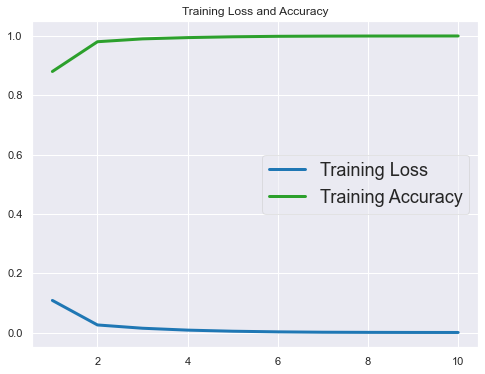

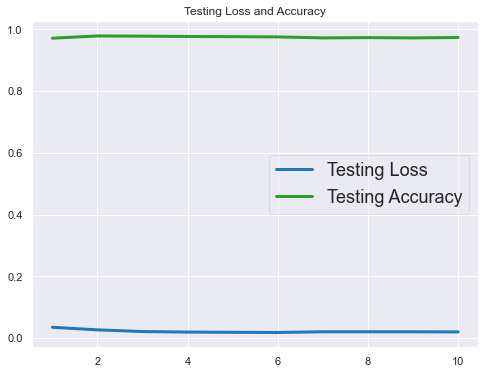

In [14]:
x = list(range(1, len(hist.epoch) + 1))
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x, hist.history['loss'], label='Training Loss', color='tab:blue', linewidth=3)
plt.plot(x, hist.history['accuracy'], label='Training Accuracy', color='tab:green', linewidth=3)
plt.title('Training Loss and Accuracy')
plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x, hist.history['val_loss'], label='Testing Loss', color='tab:blue', linewidth=3)
plt.plot(x, hist.history['val_accuracy'], label='Testing Accuracy', color='tab:green', linewidth=3)
plt.title('Testing Loss and Accuracy')
plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
plt.show()

In [15]:
set = pd.read_csv("generalization_set.csv")
correct = 0
for row in set.itertuples():
    if row[2] == 1 and model_LSTM.predict(dataset.get_tokenized_string(row[1])) > 0 or row[2] == 0 and model_LSTM.predict(dataset.get_tokenized_string(row[1])) < 0:
        correct += 1

def print_lstm(val):
    if val > 0:
        print("CLICKBAIT FOUND:", val)
    else:
        print("Not Clickbait", val)

print(str.format("Generalization Accuracy: {:.4f}", correct/set.shape[0]))

Generalization Accuracy: 0.5500


In [16]:
# Negative values are not clickbait, positive are clickbait. Magnitude indicates confidence.
print_lstm(model_LSTM.predict(dataset.get_tokenized_string("")))

CLICKBAIT FOUND: [[0.46556303]]
